# REDE

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.init as init

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

# CLASSE

In [3]:
class MinhaRede(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MinhaRede, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        ) 
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        feature  = self.features(x)
        output = self.out(feature)
        return output

In [4]:
input_size=12
hidden_size=64
output_size=1

net = MinhaRede(input_size,hidden_size,output_size).to(device)
net

MinhaRede(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)

## PERDA

In [5]:
criterion = nn.L1Loss().to(device)
criterion

L1Loss()

## OTIMIZADOR

In [6]:
optimizer = optim.Adam(
    net.parameters(), 
    lr=0.0001,
    weight_decay=0.0005
)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0005
)

# DADOS

In [7]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# day = pd.read_csv(r'c:\Users\Usuario\Desktop\datasets_pytorch\day.csv')
day = pd.read_csv(r'c:\Users\Usuario\Desktop\datasets_pytorch\hour.csv')
day

In [9]:
torch.manual_seed(1)
indices = torch.randperm(len(day)).tolist()
indices

[16105,
 15906,
 3800,
 13739,
 4767,
 3616,
 15731,
 14464,
 5032,
 3321,
 4881,
 4132,
 5407,
 4648,
 2842,
 17115,
 11683,
 4716,
 13682,
 6215,
 3367,
 11502,
 11876,
 4291,
 4812,
 14201,
 2033,
 16631,
 6428,
 6733,
 14330,
 979,
 1132,
 8460,
 12581,
 11988,
 10601,
 16791,
 3265,
 4349,
 15793,
 2290,
 8300,
 16250,
 14577,
 15828,
 9561,
 2164,
 12203,
 10983,
 16560,
 12324,
 8980,
 10147,
 15750,
 9922,
 13929,
 4793,
 14929,
 13067,
 3415,
 13666,
 4090,
 8033,
 8332,
 7752,
 6289,
 13574,
 691,
 1387,
 7789,
 158,
 9344,
 6409,
 11211,
 15147,
 9324,
 9172,
 1244,
 3249,
 14023,
 675,
 14216,
 13516,
 4879,
 9857,
 16801,
 826,
 11194,
 3858,
 10256,
 15609,
 3402,
 7830,
 1492,
 15833,
 9321,
 1502,
 15754,
 10366,
 16726,
 388,
 13647,
 15385,
 11795,
 13467,
 12672,
 15581,
 14631,
 14104,
 13594,
 16426,
 2522,
 16124,
 4768,
 9935,
 16118,
 5599,
 5859,
 12699,
 5458,
 6388,
 5934,
 13724,
 2873,
 5264,
 15964,
 1211,
 15164,
 4380,
 2866,
 11369,
 12846,
 6220,
 2192

In [10]:
size = 0.8
train_size = int(size*len(day))

df_train = day.iloc[indices[:train_size]]
df_test = day.iloc[indices[train_size:]]

In [11]:
class BicicleData(Dataset):
    def __init__(self, data):
        self.data = data.to_numpy()
        
    def __getitem__(self, idx):
        sample = np.array(self.data[idx][2:14], dtype=np.float32)  # Garante que seja um array NumPy
        label = np.array(self.data[idx][-1:], dtype=np.float32)     # Garante que seja um array NumPy

        sample = torch.from_numpy(sample)  # Converte para tensor
        label = torch.from_numpy(label)    # Converte para tensor

        return sample, label
    
    def __len__(self):
        return len(self.data)

In [12]:
train_set = BicicleData(df_train)
test_set = BicicleData(df_test)

print(train_set[0])
print(test_set[0])

(tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582]), tensor([373.]))
(tensor([ 2.0000,  1.0000,  6.0000, 20.0000,  0.0000,  6.0000,  0.0000,  2.0000,
         0.6600,  0.6212,  0.4700,  0.1940]), tensor([352.]))


In [13]:
train_loader = DataLoader(
    train_set,
    batch_size=20,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_set,
    batch_size=20,
    shuffle=False,
    num_workers=0
)

In [14]:
for batch in train_loader:
    dado,rotulo = batch
    print(dado.size(), rotulo.size())
    break

torch.Size([20, 12]) torch.Size([20, 1])


# VALIDAÇÃO

In [15]:
def train(train_loader, net, epoch):
  # Training mode
  net.train()
  epoch_loss  = []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(device)
    rotulo = rotulo.to(device)
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f' % (epoch, epoch_loss.mean(), epoch_loss.std()))
  
  return epoch_loss.mean()
    
     

def validate(test_loader, net, epoch):
  # Evaluation mode
  net.eval()
  epoch_loss  = []
  with torch.no_grad(): 
    for batch in test_loader:
      dado, rotulo = batch
      # Cast do dado na GPU
      dado = dado.to(device)
      rotulo = rotulo.to(device)
      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)
  epoch_loss = np.asarray(epoch_loss)
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f' % (epoch, epoch_loss.mean(), epoch_loss.std()))
  
  return epoch_loss.mean()

In [16]:
train_losses, test_losses = [], []
for epoch in range(500):
  # Train
  train_losses.append(train(train_loader, net, epoch))
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 157.7611 +/- 44.3423
********** Validate **********
Epoch 0, Loss: 122.5019 +/- 25.4001
#################### Train ####################
Epoch 1, Loss: 128.4349 +/- 25.8314
********** Validate **********
Epoch 1, Loss: 123.2233 +/- 30.7594
#################### Train ####################
Epoch 2, Loss: 124.7162 +/- 31.7080
********** Validate **********
Epoch 2, Loss: 115.4420 +/- 27.1144
#################### Train ####################
Epoch 3, Loss: 120.2939 +/- 25.5030
********** Validate **********
Epoch 3, Loss: 116.2046 +/- 29.3195
#################### Train ####################
Epoch 4, Loss: 119.2465 +/- 29.8110
********** Validate **********
Epoch 4, Loss: 115.3262 +/- 27.6331
#################### Train ####################
Epoch 5, Loss: 116.2800 +/- 26.7283
********** Validate **********
Epoch 5, Loss: 115.3300 +/- 29.9099
#################### Train ####################
Epoch 6, Loss: 115.4200 +/- 28.5196
**********

KeyboardInterrupt: 

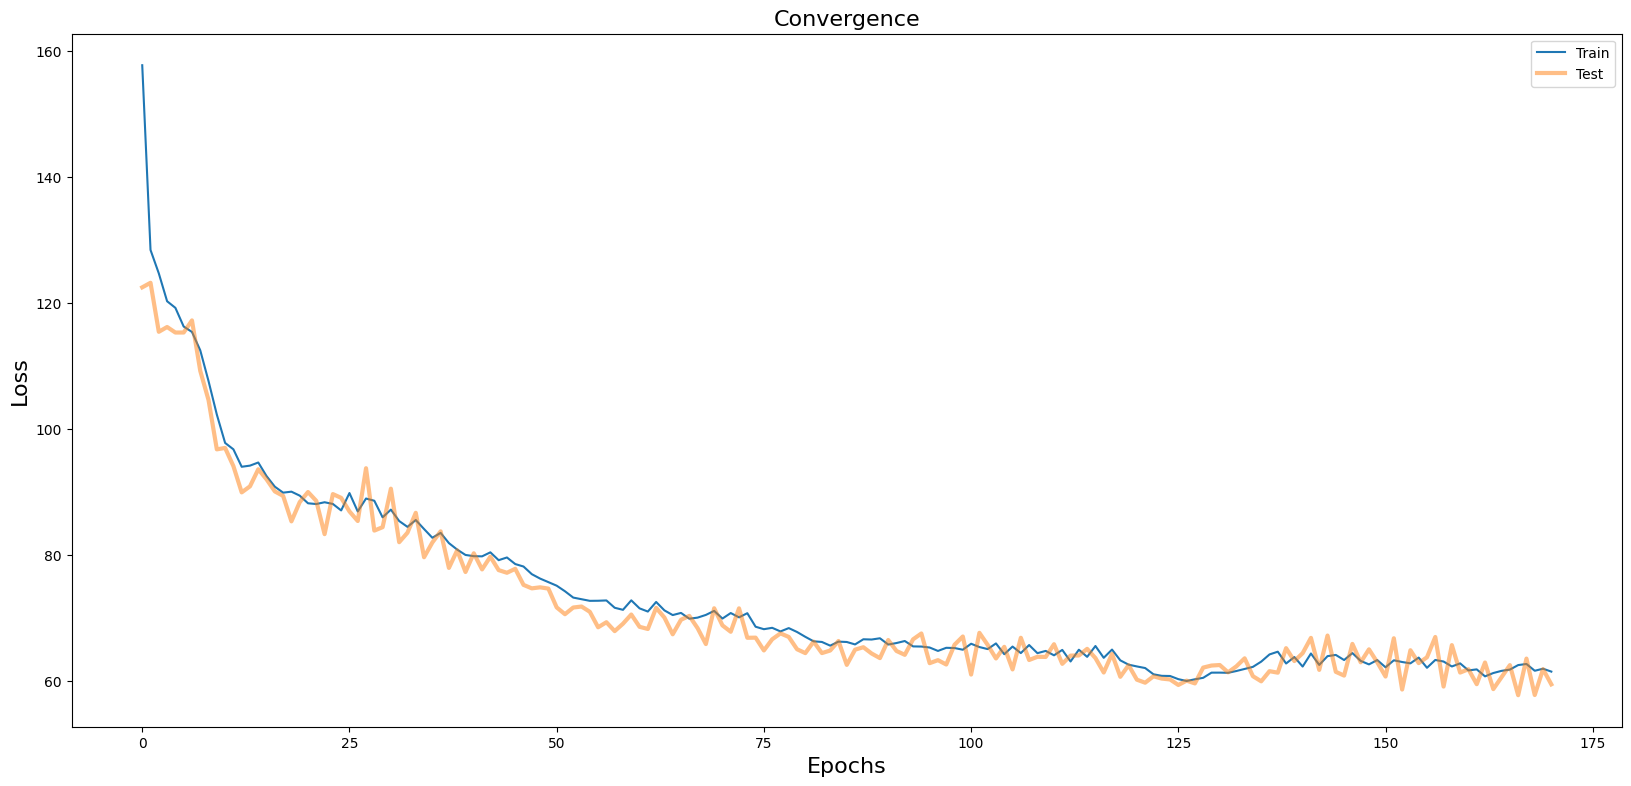

In [17]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()
     